In [1]:
import h5py
import pylab as pl
import numpy as np
import scipy.stats as sp
import matplotlib as mpl
import networkx
import progressbar
import astropy.cosmology as apc
import matplotlib.colors as mpc

In [2]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

In [3]:
pl.rc('font', size = 25)
pl.rc('legend', fontsize = 25)
# sim = h5py.File('/disk1/data1-casona/data1/cielo/simulations/LG1/LG1.hdf5', 'r')
# trees = networkx.read_multiline_adjlist('/disk1/data1-casona/data1/cielo/simulations/LG1/LG1_tree.dat')

In [4]:
Cosmo = apc.FlatLambdaCDM(H0=100, Om0=0.3175)

In [4]:
# a bunch of constants
UnitMass_in_g = 1.989e+43
UnitTime_in_s = 3.08568e+16
UnitVelocity_in_cm_per_s = 100000
UnitDensity_in_cgs = 6.7699e-22
UnitEnergy_in_cgs = 1.989e+53
GAMMA_MINUS1 = 2./3.
PROTONMASS = 1.6726e-24
BOLTZMANN = 1.3806e-16    

HMass = 1.00794
FeMass = 55.845
OMass = 15.9994
NfeNhe_sun = -4.5 # grevesse & saundall 98
NoNfe_sun = 1.33 # same

def tempFromMass(Mass, Abund, IE, ne1):
    XH = Abund[:,6]/Mass
    yHelium = (1. - XH)/(4.*XH)
    mu = (1 + 4.* yHelium)/ (1.+ yHelium + ne1 )
    temp = GAMMA_MINUS1 * IE * mu * 1.6726 / 1.3806 * 1.e-8 # / BOLTZMANN  * PROTONMASS
    temp = temp * 1e10 #   UnitEnergy_in_cgs / UnitMass_in_g;
    return temp

In [6]:
# ok, lets test tha tidal stripping at peri
Msun = 1.988*1e30 # msun in kg
kpc = 3.086*1e16 # kpc in m
G = 4.3*1e-6 # kpc/M_sun km^2/s^2
DMmass = sim['SnapNumber_128/Header/MassTable'][1]

def tidal_v2(idd, iddC, snap):
    # get tidal form anything around , lets say I dont know, what i think is close
    # 200 kpc is almost the virial radius, so 100 kpc should be good, and the center always, obviously.
    
    OFFGas = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
    OFFDM = sim['SnapNumber_{}/SubGroups/PartType1/Offsets'.format(snap)][idd].astype('int')
    OFFStars = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][idd].astype('int')
    StarMass = sim['SnapNumber_{}/PartType4/Masses'.format(snap)][OFFStars[0]:OFFStars[1]]
    GasMass = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][OFFGas[0]:OFFGas[1]]
    DMMass = DMmass*np.ones(OFFDM[1]-OFFDM[0]) 

    MassList = list(StarMass)
    MassList.extend(list(GasMass))
    MassList.extend(list(DMMass))
    MassList = np.array(MassList)

    OFFGasC = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][iddC].astype('int')
    OFFDMC = sim['SnapNumber_{}/SubGroups/PartType1/Offsets'.format(snap)][iddC].astype('int')
    OFFStarsC = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][iddC].astype('int')

    CenP = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
    CenG = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]

    distB = np.sqrt(np.sum((CenG-CenP)**2.))

    StarPosC = sim['SnapNumber_{}/PartType4/Coordinates'.format(snap)][OFFStarsC[0]:OFFStarsC[1]]
    GasPosC = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][OFFGasC[0]:OFFGasC[1]]
    DMPosC = sim['SnapNumber_{}/PartType1/Coordinates'.format(snap)][OFFDMC[0]:OFFDMC[1]]

    xSC, ySC, zSC = StarPosC[:,0] - CenP[0], StarPosC[:,1] - CenP[1], StarPosC[:,2] - CenP[2]
    rSC = np.sqrt(xSC**2.+ySC**2.+zSC**2.)
    iSCN = np.where(rSC<distB)

    xGC, yGC, zGC = GasPosC[:,0] - CenP[0], GasPosC[:,1] - CenP[1], GasPosC[:,2] - CenP[2]
    rGC = np.sqrt(xGC**2.+yGC**2.+zGC**2.)
    iGCN = np.where(rGC<distB)

    xDC, yDC, zDC = DMPosC[:,0] - CenP[0], DMPosC[:,1] - CenP[1], DMPosC[:,2] - CenP[2]
    rDC = np.sqrt(xDC**2.+yDC**2.+zDC**2.)
    iDCN = np.where(rDC<distB)

    SMassC = sim['SnapNumber_{}/PartType4/Masses'.format(snap)][OFFStarsC[0]:OFFStarsC[1]]
    StarMassC = np.sum(SMassC[iSCN])
    GMassC = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][OFFGasC[0]:OFFGasC[1]]
    GasMassC = np.sum(GMassC[iGCN])
    DMMassC = DMmass*(iDCN[0].size) 

    CenMass = StarMassC+GasMassC+DMMassC
    
    CenPos = CenP-CenG
    
    GasPos = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][OFFGas[0]:OFFGas[1]]
    Gx, Gy, Gz = GasPos[:,0] - CenG[0], GasPos[:,1] - CenG[1], GasPos[:,2] - CenG[2]
    StarPos = sim['SnapNumber_{}/PartType4/Coordinates'.format(snap)][OFFStars[0]:OFFStars[1]]
    Sx, Sy, Sz = StarPos[:,0] - CenG[0], StarPos[:,1] - CenG[1], StarPos[:,2] - CenG[2]
    DMPos = sim['SnapNumber_{}/PartType1/Coordinates'.format(snap)][OFFDM[0]:OFFDM[1]]
    Dx, Dy, Dz = DMPos[:,0] - CenG[0], DMPos[:,1] - CenG[1], DMPos[:,2] - CenG[2]
    
    X, Y, Z = [], [], []
    X.extend(list(Sx)), Y.extend(list(Sy)), Z.extend(list(Sz))
    X.extend(list(Gx)), Y.extend(list(Gy)), Z.extend(list(Gz))
    X.extend(list(Dx)), Y.extend(list(Dy)), Z.extend(list(Dz))
    
    X, Y, Z = np.array(X), np.array(Y), np.array(Z)
    
    # I think we got all, so far.
    Xt, Yt, Zt = [], [], []
    
    CenMassM = CenMass*1e10 # in M_sun
    
    for ms, xx, yy, zz in zip(MassList, X, Y, Z):
        msS = ms*1e10 # same
        dist = np.sqrt((xx-CenPos[0])**2+(yy-CenPos[1])**2+(zz-CenPos[2])**2)
        cross = np.cross(np.array([xx, yy, zz]), CenPos)
        tt = G*msS*CenMassM*cross/dist**3. # i dont know if this is gonna make sense, i guess is not to heavy
        
        Xt.append(tt[0]), Yt.append(tt[1]), Zt.append(tt[2])
        
#     Xt, Yt, Zt = np.array(Xt), np.array(Yt), np.array(Zt)
    
#     XTT, YTT, ZTT = np.sum(Xt), np.sum(Yt), np.sum(Zt)
#     To = np.sqrt(XTT**2+YTT**2+ZTT**2.)

    
    # and lets find galaxies around, I mean, any galaxy will suffice
    OtherGals = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][()]
    #remove the central
#     OtherG = np.delete(OtherGals, cen, 0)
    distFromOt = OtherGals - CenG
    dddist = np.sqrt(distFromOt[:,0]**2+distFromOt[:,1]**2+distFromOt[:,2]**2.)
    
    ik = np.where(dddist<100)[0] # idk, i can change that.
    
    iik = ik[np.where((ik!=iddC) & (ik!=idd))[0]]
    for ii in iik:
        ddist = dddist[ii]
        Tpos = distFromOt[ii] 
        
        CenT = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][ii]
        
        OFFGasT = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][ii].astype('int')
        OFFDMT = sim['SnapNumber_{}/SubGroups/PartType1/Offsets'.format(snap)][ii].astype('int')
        OFFStarsT = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][ii].astype('int')
        
        StarPosT = sim['SnapNumber_{}/PartType4/Coordinates'.format(snap)][OFFStarsT[0]:OFFStarsT[1]]
        GasPosT = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][OFFGasT[0]:OFFGasT[1]]
        DMPosT = sim['SnapNumber_{}/PartType1/Coordinates'.format(snap)][OFFDMT[0]:OFFDMT[1]]

        xST, yST, zST = StarPosT[:,0] - CenT[0], StarPosT[:,1] - CenT[1], StarPosT[:,2] - CenT[2]
        rST = np.sqrt(xST**2.+yST**2.+zST**2.)
        iSTN = np.where(rST<ddist)
        
        xGT, yGT, zGT = GasPosT[:,0] - CenT[0], GasPosT[:,1] - CenT[1], GasPosT[:,2] - CenT[2]
        rGT = np.sqrt(xGT**2.+yGT**2.+zGT**2.)
        iGTN = np.where(rGT<ddist)

        xDT, yDT, zDT = DMPosT[:,0] - CenT[0], DMPosT[:,1] - CenT[1], DMPosT[:,2] - CenT[2]
        rDT = np.sqrt(xDT**2.+yDT**2.+zDT**2.)
        iDTN = np.where(rDT<ddist)

        SMassT = sim['SnapNumber_{}/PartType4/Masses'.format(snap)][OFFStarsT[0]:OFFStarsT[1]]
        StarMassT = np.sum(SMassT[iSTN])
        GMassT = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][OFFGasT[0]:OFFGasT[1]]
        GasMassT = np.sum(GMassT[iGTN])
        DMMassT = DMmass*(iDTN[0].size) 

        TMass = StarMassT+GasMassT+DMMassT
        TMass = TMass*1e10
        
#         XtT, YtT, ZtT = [], [], []
        for ms, xx, yy, zz in zip(MassList, X, Y, Z):
            msS = ms*1e10 # same
            dist = np.sqrt((xx-Tpos[0])**2+(yy-Tpos[1])**2+(zz-Tpos[2])**2)
            cross = np.cross(np.array([xx, yy, zz]), Tpos)
            tt = G*msS*TMass*cross/dist**3. # i dont know if this is gonna make sense, i guess is not too heavy

            Xt.append(tt[0]), Yt.append(tt[1]), Zt.append(tt[2])

#         XtT, YtT, ZtT = np.array(XtT), np.array(YtT), np.array(ZtT)

#         XTTt, YTTt, ZTTt = np.sum(XtT), np.sum(YtT), np.sum(ZtT)
        
#         Tot = np.sqrt(XTTt**2+YTTt**2+ZTTt**2.)
#         print(np.log10(To), np.log10(Tot))
#         To += Tot
    
    Xt, Yt, Zt = np.array(Xt), np.array(Yt), np.array(Zt)
    
    XTT, YTT, ZTT = np.sum(Xt), np.sum(Yt), np.sum(Zt)
    To = np.sqrt(XTT**2+YTT**2+ZTT**2.)
    
    # but this is in Km^s/s^2 M_sun, hey, thats not too bad
    ToNM = To*Msun*1e6 # now is in Nm
    
    return ToNM, To, np.sum(MassList)*1e10 # return both, just in case

In [7]:
# how to test this? let see if not fall, for start
 tidal_v2(4338, 4337, 128)

(4.646920167480997e+47, 233748499370.27148, 4097852212.7104745)

In [8]:
np.log10(4097852212)

9.612556291627339

In [9]:
def getperi(gal, center):
    uniqueID = int(127*1e6+gal)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    uniqueIDC = int(127*1e6+center)
    streeC = networkx.dfs_tree(trees, str(uniqueIDC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
    
    r, thesnap, rphys = [], [], []
    
    proy = []
    iddS, iddSC = [], []
    for m, mC in zip(mtree, mtreeC):
        snap, idd = split_unique_id(int(m))
        snapC, iddC = split_unique_id(int(mC))
        
        group = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][iddC]
        r200 = sim['SnapNumber_{}/Groups/Group_R_Crit200'.format(snap)][group]

        galPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
        cenPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
        
        vec =  galPos - cenPos
        rad = np.sqrt(np.sum(vec**2.))
        
        r.append(rad/r200)
        rphys.append(rad)
        thesnap.append(snap)
        proy.append(vec)
        iddS.append(idd)
        iddSC.append(iddC)
        
    r, rphys, thesnap = np.array(r), np.array(rphys), np.array(thesnap)
    proy = np.array(proy)
    iddS, iddSC = np.array(iddS), np.array(iddSC)
    
    ir = np.where(r<2.) # no further, just in case
    
    r, rphys, thesnap = r[ir], rphys[ir], thesnap[ir]
    proy = proy[ir]
    iddS = iddS[ir]
    iddSC = iddSC[ir]
    
    angles = []
    for i in range(len(proy)-1):
        dot = np.dot(proy[i], proy[i-1])
        cos = dot/(rphys[i]*rphys[i-1])
        if cos>1 and cos<1.001: # a failsafe
            cos=1.
        angles.append(np.arccos(cos))
        
    angles = np.array(angles)
        
    # this is backwards, it starts in teh future and it moves formward.
    r, rphys, thesnap = np.flip(r), np.flip(rphys), np.flip(thesnap)
    
    angles = np.flip(angles)
    
    iddS = np.flip(iddS)
    
    pre, r0 = 0, rphys[0]
    for i, rr in enumerate(rphys[1:]):
        if rr>r0:
            break
        else:
            r0 = rr
            pre = i+1
            
            
    physD, Snap , theID, theIDC = rphys[pre], thesnap[pre], iddS[pre], iddSC[pre]
    angles = angles[pre-1:]
    
    mmr = rphys.min()
    firstsnap = thesnap.min()
    Nturn = np.sum(angles)/(2.*np.pi)
    
    return physD, Snap, mmr, firstsnap, Nturn, theID, theIDC

In [10]:
#ok, now the serialized version of the get particles for each Satellite, lets see.
TdayTotalIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][()] # need this first
I= np.identity(3) # and this

In [11]:
# ok, lets calculate some ram pressures with only hot gas densities, this will be reduced a lot
Msun = 1.988*1e30
kpc = 3.086*1e19

def getTidal(gal, central):
    
    z, TSt, snaplist, dist, galMass = [], [], [], [], []
    
    Idlist, snapst  = [], []
    
    group = sim['SnapNumber_128/SubGroups/GroupNumber'][central]
    r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]
    
    uniqueID = int(127*1e6+gal)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    uniqueIDC = int(127*1e6+central)
    streeC = networkx.dfs_tree(trees, str(uniqueIDC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
    
    ccc = 0
    for m, mC in zip(mtree, mtreeC):
        snap, idd = split_unique_id(int(m))
        snap, iddC = split_unique_id(int(mC))

        galPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
        groupPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
        pos = np.sqrt(np.sum((galPos-groupPos)**2))
        
        if pos>2*r200:
            break
        
        ToDontCare, To, gMass = tidal_v2(idd, iddC, snap)
        
        zs = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
        
        snaplist.append(snap)
        TSt.append(To)
        dist.append(pos)
        
        # and now lost masses
        offgal = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][offgal[0]:offgal[1]]
        
        Idlist.extend(list(tempIds))
        snapst.extend([snap]*tempIds.size)
        z.append(zs)
        galMass.append(gMass)
        
        print(snap)
        
    z, TSt, snaplist, dist = np.array(z), np.array(TSt), np.array(snaplist), np.array(dist)
    galMass = np.array(galMass)
    
    Idlist = np.array(Idlist)
    snapst = np.array(snapst)
    
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    snapst= snapst[Idunique]
    
#     IndexToday = np.in1d(TdayTotalIDs, Idlist)
#     IndexToday_ = np.where(IndexToday)[0]
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][gal].astype('int')
    
    # lets remove the ones that are not part of the group today.
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    # and snaps
    SurvIds_ = TdayTotalIDs[IndexT_]
    iidex = np.in1d(Idlist, SurvIds_)
    iidex_ = np.where(iidex)[0]
    snapst_, Idlist_ = snapst[iidex_], Idlist[iidex_]

    is1 = np.argsort(SurvIds_) # the target
    is2 = np.argsort(Idlist_)

    snaporder = np.zeros(IndexT_.size)
    
    snaporder[is1] = snapst_[is2]
    
    GasMasses = sim['SnapNumber_128/PartType0/Masses'][IndexT_]
    
    Gas = []
    for s in snaplist:
        k = np.where(snaporder==s)
        GasT = GasMasses[k]
        Gas.append(np.sum(GasT))
    
    Gas = np.array(Gas)
    
    return z, TSt, dist, Gas*1e10, galMass

In [12]:
# ok, lets test this
gal, cen = 4338, 4337
z, TSt, dist, Gas, gMass = getTidal(gal, cen)

print(z.size, dist.size)

Time = Cosmo.lookback_time(z).value

group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]
r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

ii = np.where(dist<2*r200)
z, TSt, dist, Gas, Time, gMass = z[ii], TSt[ii], dist[ii], Gas[ii], Time[ii], gMass[ii]

physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
zPeri = sim['SnapNumber_{}/Header/Redshift'.format(Snap)][()]
TPeri = Cosmo.lookback_time(zPeri).value

127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
25 25


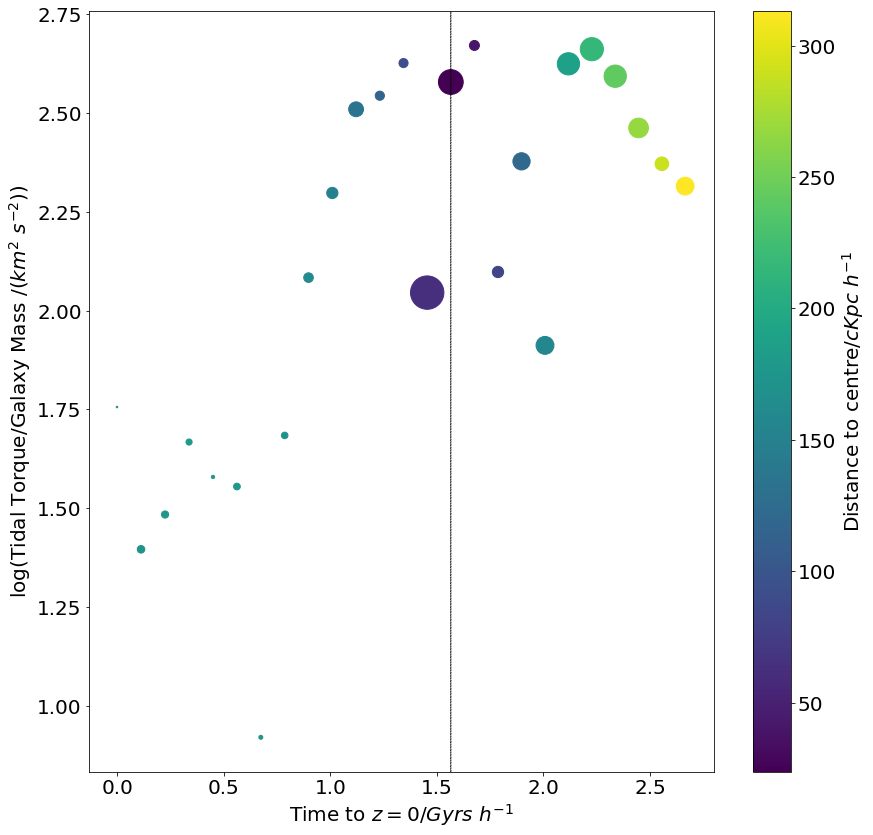

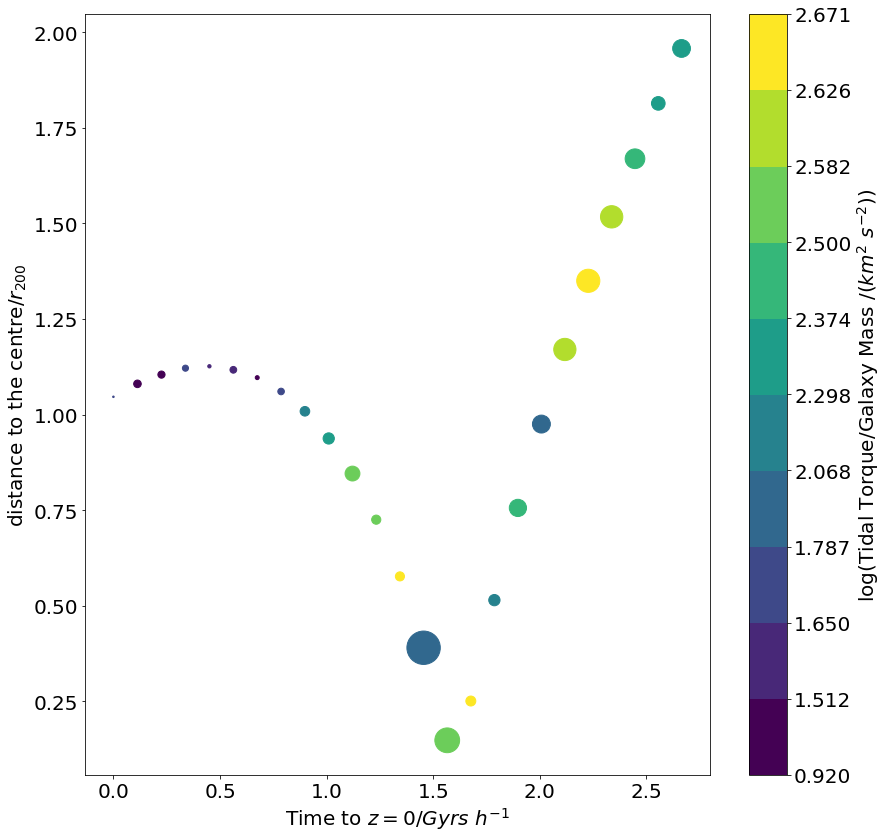

In [13]:
pl.figure(figsize=(14,14))

pl.scatter(Time, np.log10(TSt/gMass), marker='o', c=dist, s=Gas/5e5)

pl.ylabel('log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')

pl.arrow(TPeri, 0., 0., 1000., ls=':', color='black')

bar = pl.colorbar(label='Distance to centre$/cKpc\,\,h^{-1}$')

pl.figure(figsize=(14,14))

vaper = np.linspace(0, 100, 11)
papels2 = np.percentile(np.log10(TSt/gMass), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time, dist/r200, s=Gas/5e5, c=np.log10(TSt/gMass), norm=norm2)

bar = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)')
bar.set_ticks(papels2)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

# and collect what i need
TByMass_4338, Gas_4338 = TSt/gMass, Gas

127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
41 41


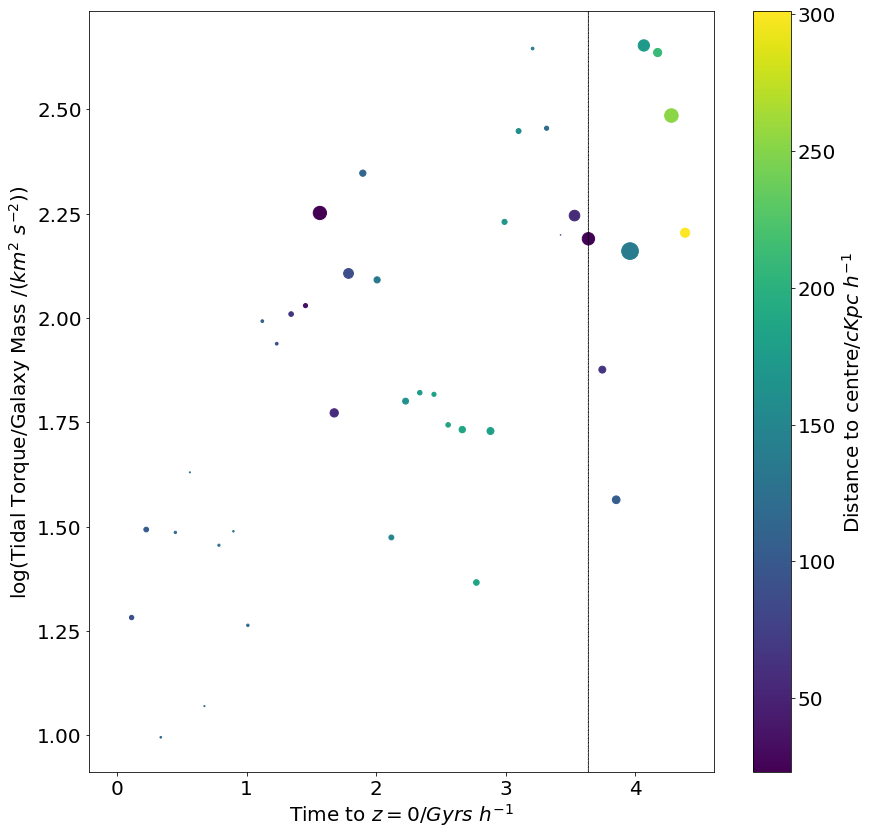

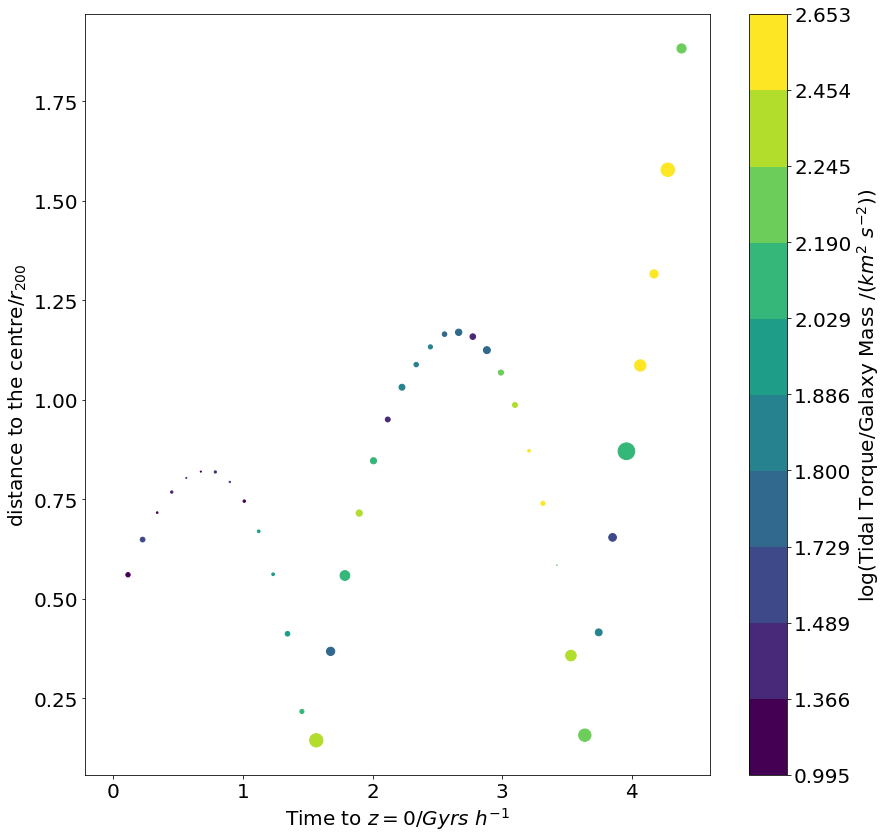

In [14]:
# ok, lets test this
gal, cen = 4339, 4337
z, TSt, dist, Gas, gMass = getTidal(gal, cen)

print(z.size, dist.size)

Time = Cosmo.lookback_time(z).value

group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]
r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

ii = np.where(dist<2*r200)
z, TSt, dist, Gas, Time, gMass = z[ii], TSt[ii], dist[ii], Gas[ii], Time[ii], gMass[ii]

physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
zPeri = sim['SnapNumber_{}/Header/Redshift'.format(Snap)][()]
TPeri = Cosmo.lookback_time(zPeri).value

pl.figure(figsize=(14,14))

pl.scatter(Time, np.log10(TSt/gMass), marker='o', c=dist, s=Gas/5e5)

pl.ylabel('log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')

pl.arrow(TPeri, 0., 0., 1000., ls=':', color='black')

bar = pl.colorbar(label='Distance to centre$/cKpc\,\,h^{-1}$')

pl.figure(figsize=(14,14))

vaper = np.linspace(0, 100, 11)
papels2 = np.percentile(np.log10(TSt/gMass), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time, dist/r200, s=Gas/5e5, c=np.log10(TSt/gMass), norm=norm2)

bar = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)')
bar.set_ticks(papels2)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

# and collect what i need
TByMass_4339, Gas_4339 = TSt/gMass, Gas

127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
25 25


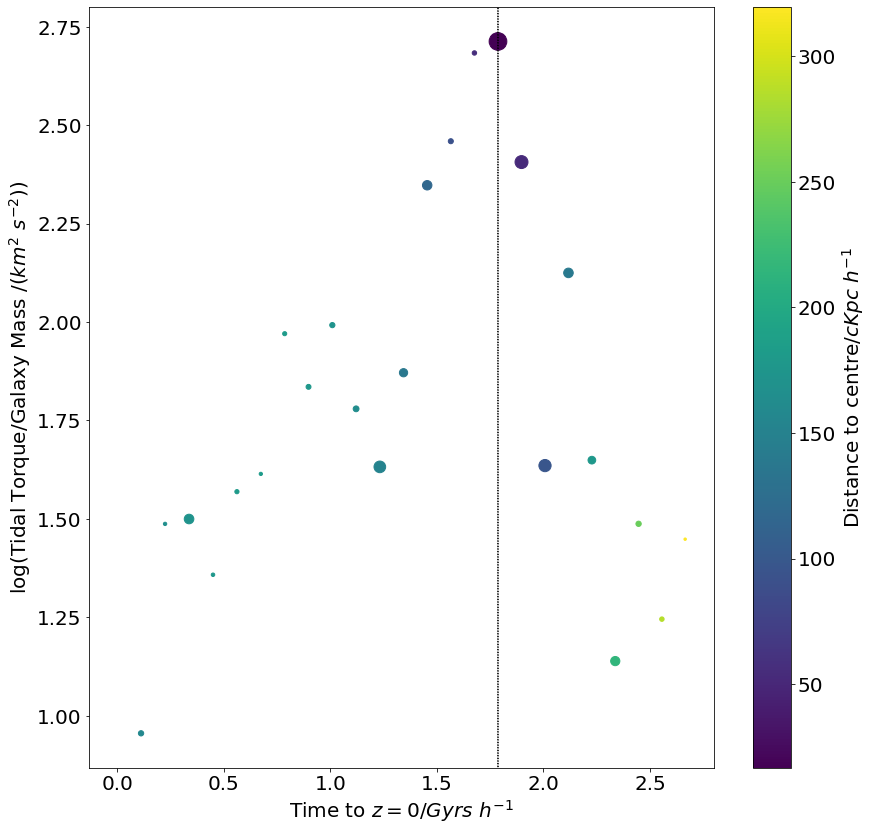

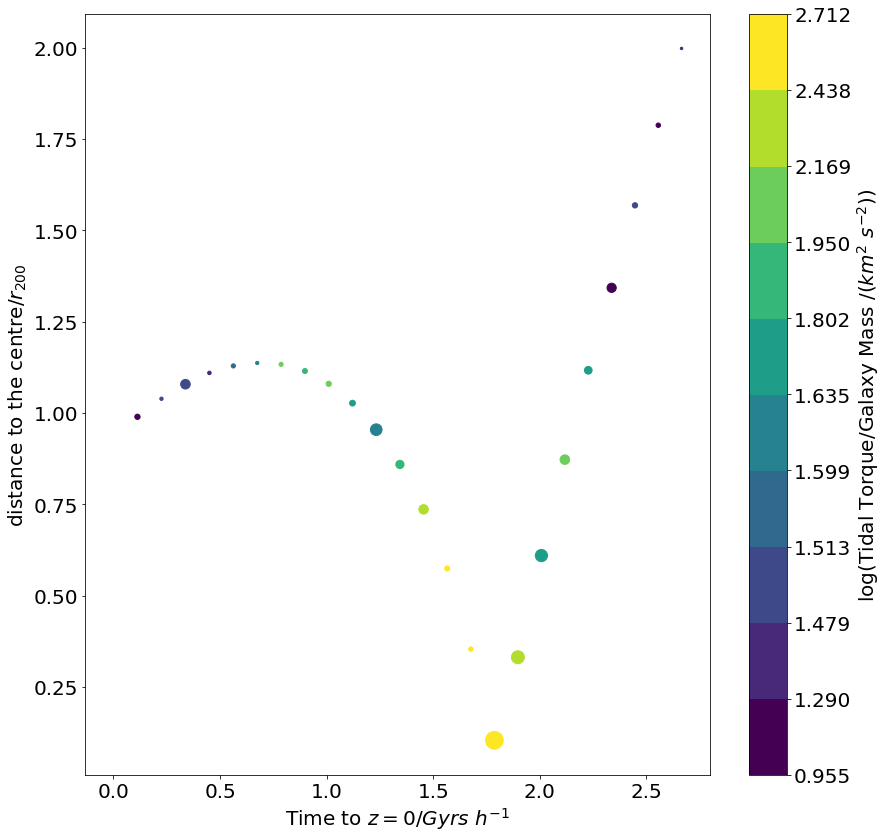

In [15]:
# ok, lets test this
gal, cen = 4341, 4337
z, TSt, dist, Gas, gMass = getTidal(gal, cen)

print(z.size, dist.size)

Time = Cosmo.lookback_time(z).value

group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]
r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

ii = np.where(dist<2*r200)
z, TSt, dist, Gas, Time, gMass = z[ii], TSt[ii], dist[ii], Gas[ii], Time[ii], gMass[ii]

physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
zPeri = sim['SnapNumber_{}/Header/Redshift'.format(Snap)][()]
TPeri = Cosmo.lookback_time(zPeri).value

pl.figure(figsize=(14,14))

pl.scatter(Time, np.log10(TSt/gMass), marker='o', c=dist, s=Gas/5e5)

pl.ylabel('log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')

pl.arrow(TPeri, 0., 0., 1000., ls=':', color='black')

bar = pl.colorbar(label='Distance to centre$/cKpc\,\,h^{-1}$')

pl.figure(figsize=(14,14))

vaper = np.linspace(0, 100, 11)
papels2 = np.percentile(np.log10(TSt/gMass), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time, dist/r200, s=Gas/5e5, c=np.log10(TSt/gMass), norm=norm2)

bar = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)')
bar.set_ticks(papels2)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

# and collect what i need
TByMass_4341, Gas_4341 = TSt/gMass, Gas

127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
45 45


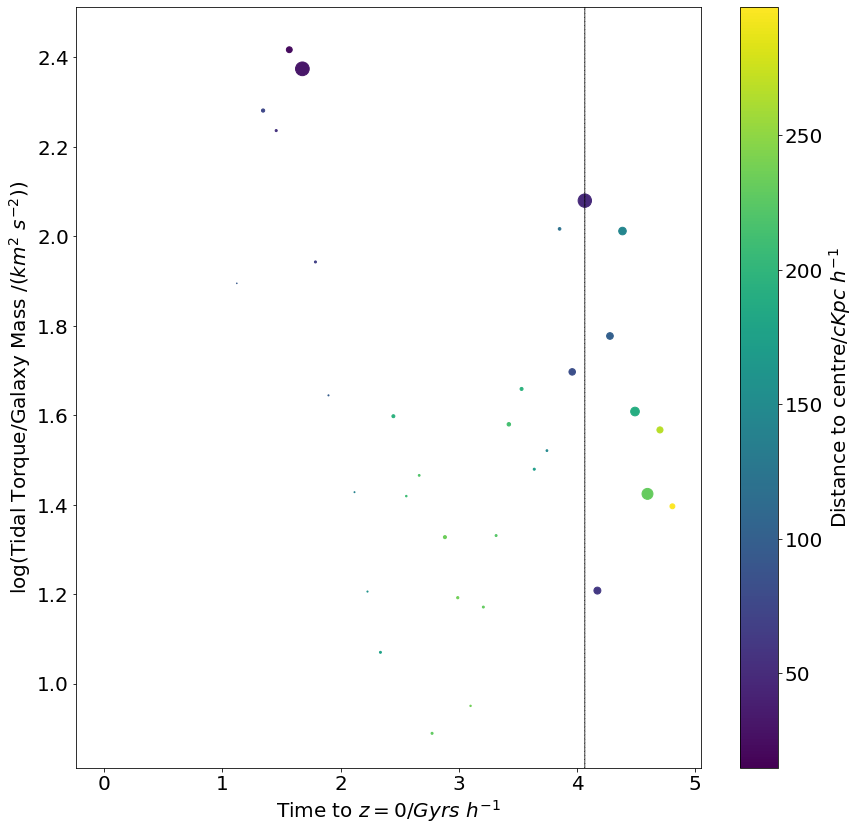

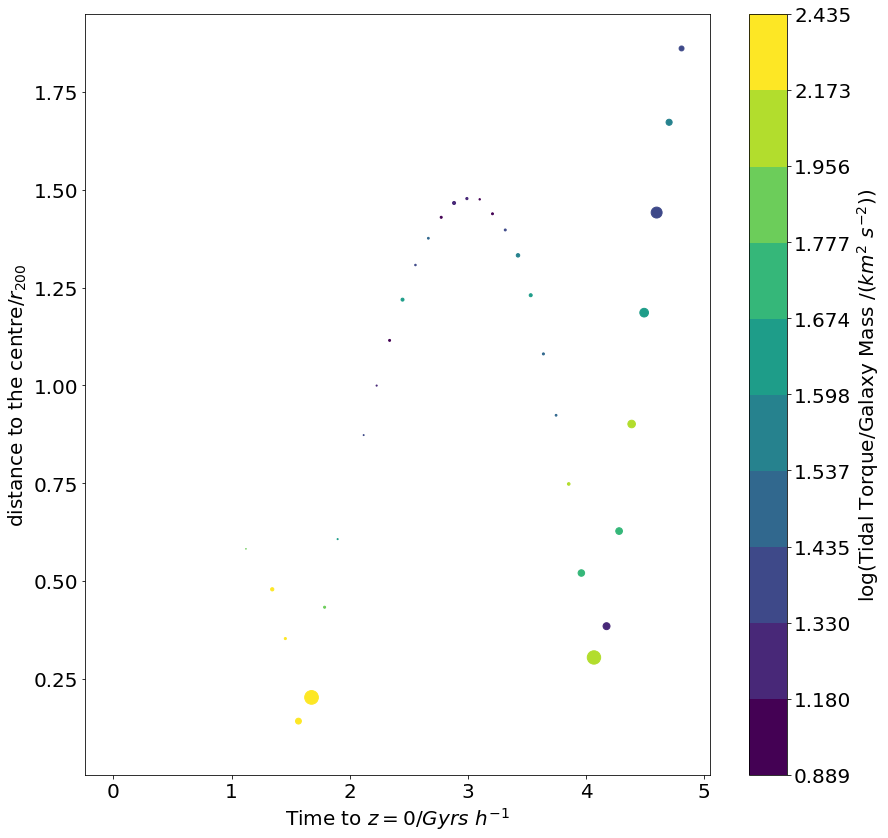

In [16]:
# ok, lets test this
gal, cen = 4343, 4337
z, TSt, dist, Gas, gMass = getTidal(gal, cen)

print(z.size, dist.size)

Time = Cosmo.lookback_time(z).value

group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]
r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

ii = np.where(dist<2*r200)
z, TSt, dist, Gas, Time, gMass = z[ii], TSt[ii], dist[ii], Gas[ii], Time[ii], gMass[ii]

physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
zPeri = sim['SnapNumber_{}/Header/Redshift'.format(Snap)][()]
TPeri = Cosmo.lookback_time(zPeri).value

pl.figure(figsize=(14,14))

pl.scatter(Time, np.log10(TSt/gMass), marker='o', c=dist, s=Gas/5e5)

pl.ylabel('log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')

pl.arrow(TPeri, 0., 0., 1000., ls=':', color='black')

bar = pl.colorbar(label='Distance to centre$/cKpc\,\,h^{-1}$')


pl.figure(figsize=(14,14))

vaper = np.linspace(0, 100, 11)
papels2 = np.percentile(np.log10(TSt/gMass), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time, dist/r200, s=Gas/5e5, c=np.log10(TSt/gMass), norm=norm2)

bar = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)')
bar.set_ticks(papels2)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

# and collect what i need
TByMass_4343, Gas_4343 = TSt/gMass, Gas

127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
36 36


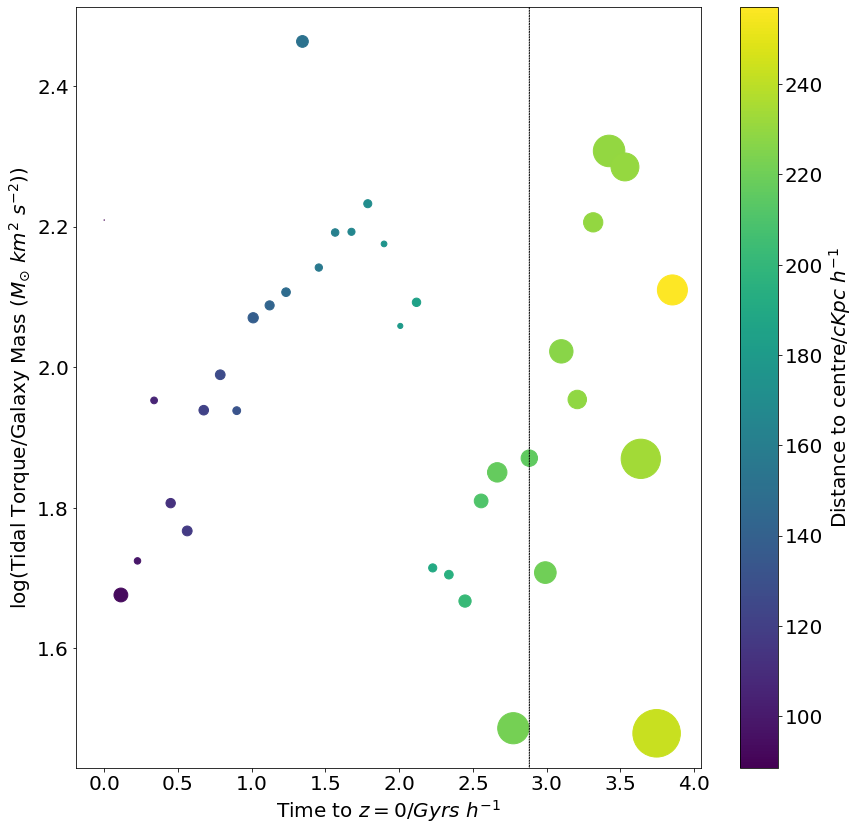

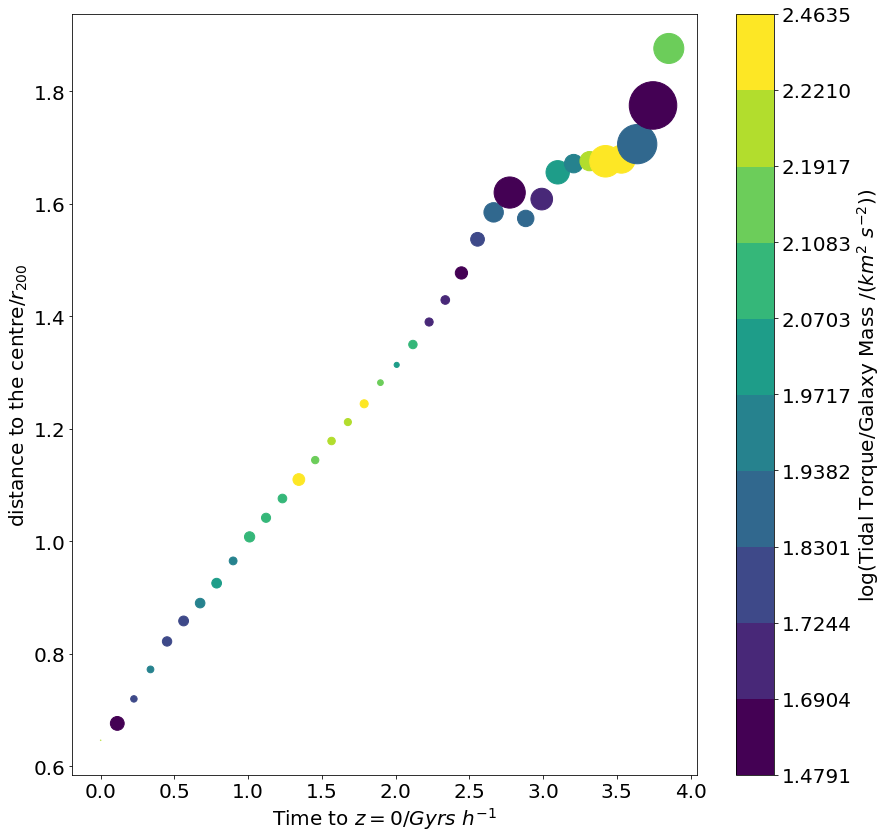

In [17]:
# ok, lets test this
gal, cen = 4470, 4469
z, TSt, dist, Gas, gMass = getTidal(gal, cen)

print(z.size, dist.size)

Time = Cosmo.lookback_time(z).value

group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]
r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

ii = np.where(dist<2*r200)
z, TSt, dist, Gas, Time, gMass = z[ii], TSt[ii], dist[ii], Gas[ii], Time[ii], gMass[ii]

physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
zPeri = sim['SnapNumber_{}/Header/Redshift'.format(Snap)][()]
TPeri = Cosmo.lookback_time(zPeri).value

pl.figure(figsize=(14,14))

pl.scatter(Time, np.log10(TSt/gMass), marker='o', c=dist, s=Gas/5e5)

pl.ylabel('log(Tidal Torque/Galaxy Mass $(M_{\odot}\,\,km^2\,\,s^{-2})$)')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')

pl.arrow(TPeri, 0., 0., 1000., ls=':', color='black')

bar = pl.colorbar(label='Distance to centre$/cKpc\,\,h^{-1}$')


pl.figure(figsize=(14,14))

vaper = np.linspace(0, 100, 11)
papels2 = np.percentile(np.log10(TSt/gMass), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time, dist/r200, s=Gas/5e5, c=np.log10(TSt/gMass), norm=norm2)

bar = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)')
bar.set_ticks(papels2)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

# and collect what i need
TByMass_4470, Gas_4470 = TSt/gMass, Gas

127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
34 34


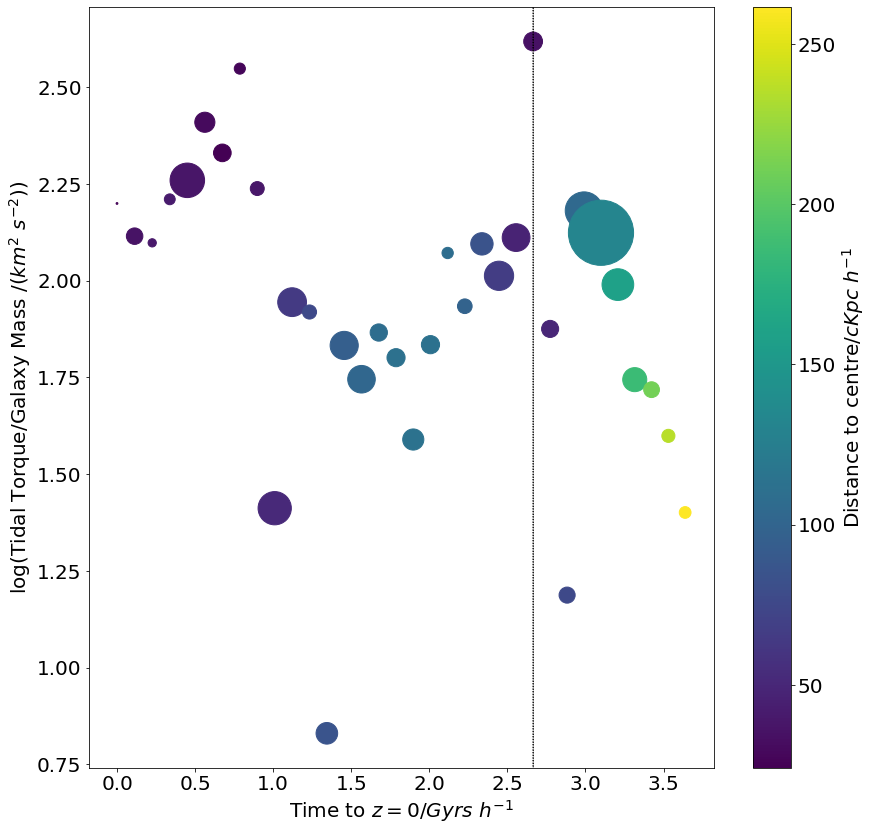

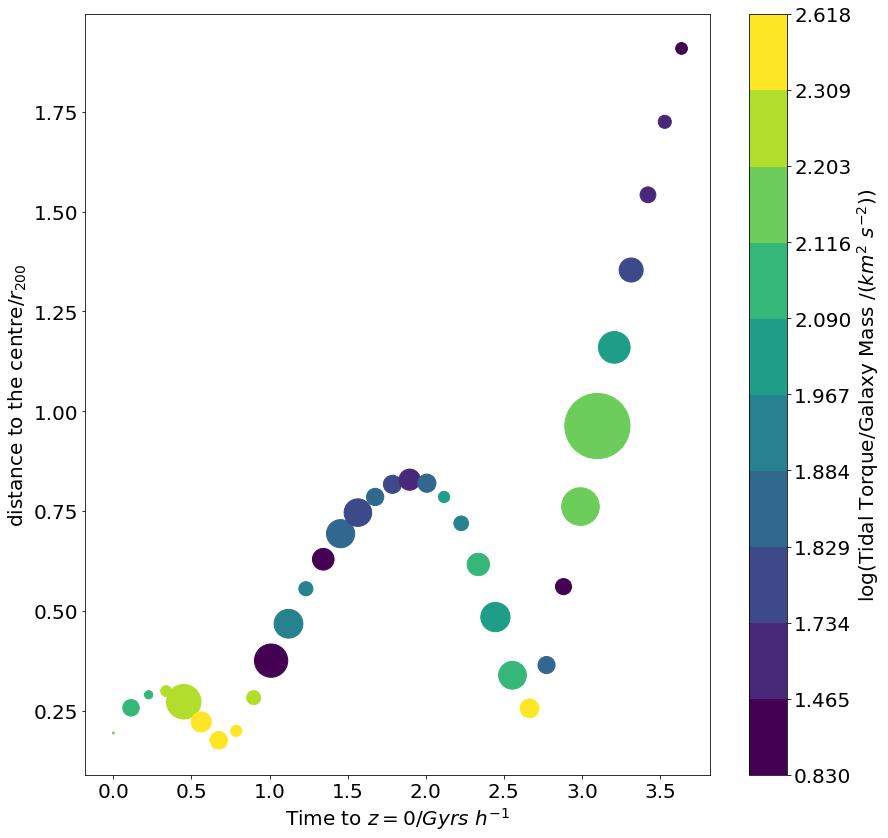

In [18]:
# ok, lets test this
gal, cen = 4471, 4469
z, TSt, dist, Gas, gMass = getTidal(gal, cen)

print(z.size, dist.size)

Time = Cosmo.lookback_time(z).value

group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]
r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

ii = np.where(dist<2*r200)
z, TSt, dist, Gas, Time, gMass = z[ii], TSt[ii], dist[ii], Gas[ii], Time[ii], gMass[ii]

physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
zPeri = sim['SnapNumber_{}/Header/Redshift'.format(Snap)][()]
TPeri = Cosmo.lookback_time(zPeri).value

pl.figure(figsize=(14,14))

pl.scatter(Time, np.log10(TSt/gMass), marker='o', c=dist, s=Gas/5e5)

pl.ylabel('log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')

pl.arrow(TPeri, 0., 0., 1000., ls=':', color='black')

bar = pl.colorbar(label='Distance to centre$/cKpc\,\,h^{-1}$')

pl.figure(figsize=(14,14))

vaper = np.linspace(0, 100, 11)
papels2 = np.percentile(np.log10(TSt/gMass), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time, dist/r200, s=Gas/5e5, c=np.log10(TSt/gMass), norm=norm2)

bar = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)')
bar.set_ticks(papels2)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

# and collect what i need
TByMass_4471, Gas_4471 = TSt/gMass, Gas

127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
21 21


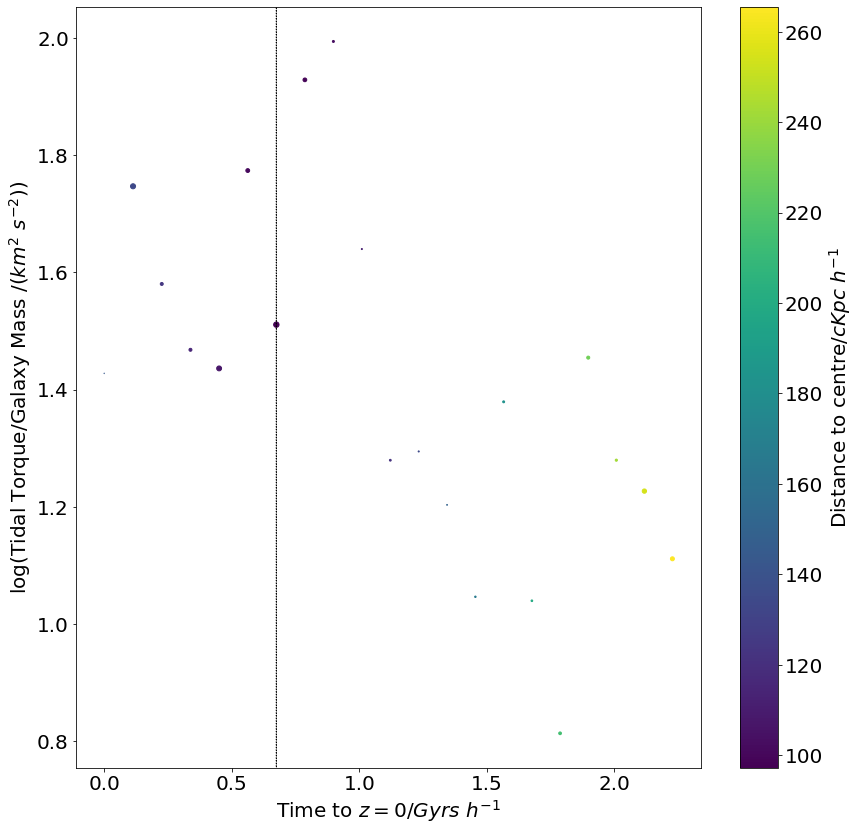

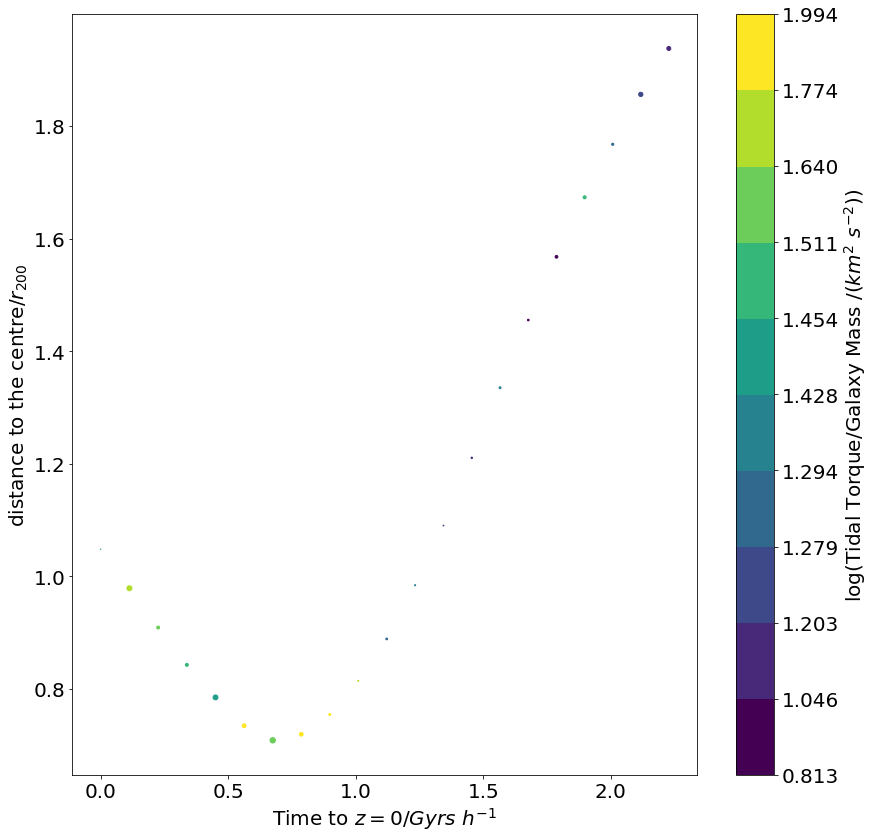

In [19]:
# ok, lets test this
gal, cen = 4473, 4469
z, TSt, dist, Gas, gMass = getTidal(gal, cen)

print(z.size, dist.size)

Time = Cosmo.lookback_time(z).value

group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]
r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

ii = np.where(dist<2*r200)
z, TSt, dist, Gas, Time, gMass = z[ii], TSt[ii], dist[ii], Gas[ii], Time[ii], gMass[ii]

physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
zPeri = sim['SnapNumber_{}/Header/Redshift'.format(Snap)][()]
TPeri = Cosmo.lookback_time(zPeri).value

pl.figure(figsize=(14,14))

pl.scatter(Time, np.log10(TSt/gMass), marker='o', c=dist, s=Gas/5e5)

pl.ylabel('log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')

pl.arrow(TPeri, 0., 0., 1000., ls=':', color='black')

bar = pl.colorbar(label='Distance to centre$/cKpc\,\,h^{-1}$')

pl.figure(figsize=(14,14))

vaper = np.linspace(0, 100, 11)
papels2 = np.percentile(np.log10(TSt/gMass), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time, dist/r200, s=Gas/5e5, c=np.log10(TSt/gMass), norm=norm2)

bar = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)')
bar.set_ticks(papels2)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

# and collect what i need
TByMass_4473, Gas_4473 = TSt/gMass, Gas

127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
32 32


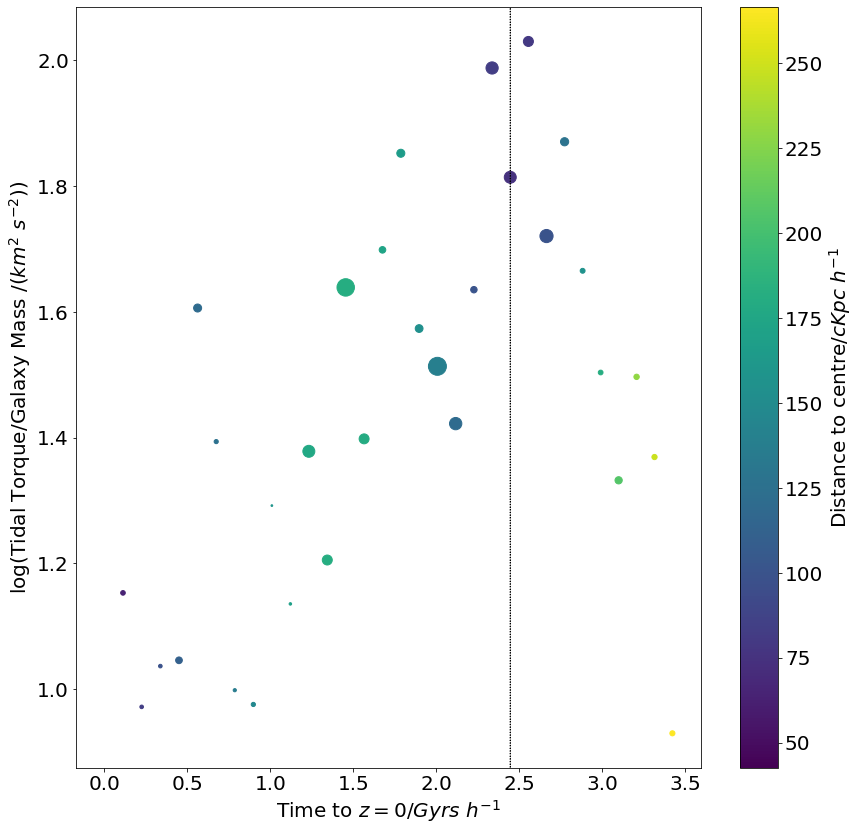

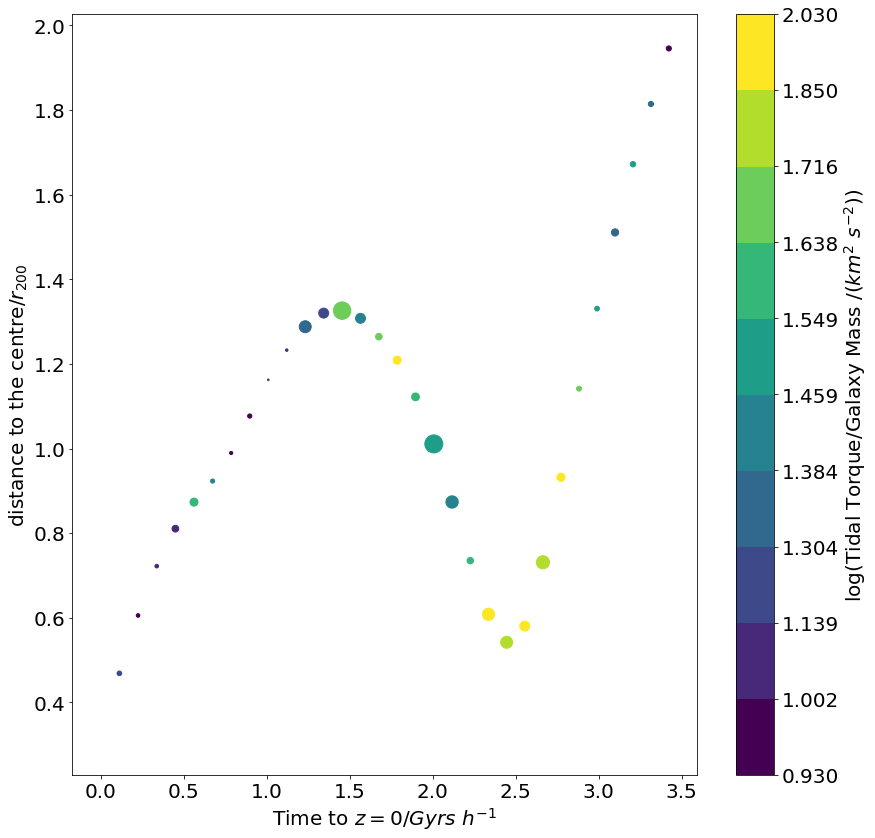

In [20]:
# ok, lets test this
gal, cen = 4474, 4469
z, TSt, dist, Gas, gMass = getTidal(gal, cen)

print(z.size, dist.size)

Time = Cosmo.lookback_time(z).value

group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]
r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

ii = np.where(dist<2*r200)
z, TSt, dist, Gas, Time, gMass = z[ii], TSt[ii], dist[ii], Gas[ii], Time[ii], gMass[ii]

physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
zPeri = sim['SnapNumber_{}/Header/Redshift'.format(Snap)][()]
TPeri = Cosmo.lookback_time(zPeri).value

pl.figure(figsize=(14,14))

pl.scatter(Time, np.log10(TSt/gMass), marker='o', c=dist, s=Gas/5e5)

pl.ylabel('log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')

pl.arrow(TPeri, 0., 0., 1000., ls=':', color='black')

bar = pl.colorbar(label='Distance to centre$/cKpc\,\,h^{-1}$')

pl.figure(figsize=(14,14))

vaper = np.linspace(0, 100, 11)
papels2 = np.percentile(np.log10(TSt/gMass), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time, dist/r200, s=Gas/5e5, c=np.log10(TSt/gMass), norm=norm2)

bar = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)')
bar.set_ticks(papels2)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

# and collect what i need
TByMass_4474, Gas_4474 = TSt/gMass, Gas

In [4]:
# I skip the previous

T = h5py.File('Derived_Data_3.h5', 'r')

dist_4338 = T['g4338/distance'][()]
Time_4338 = T['g4338/time'][()]
cosC_4338 = T['g4338/CosCen'][()]
cosV_4338 = T['g4338/CosVel'][()]
RP_4338 = T['g4338/RP'][()]
TSt_4338 = T['g4338/TSt'][()]
gMass_4338 = T['g4338/gMass'][()]
SFR_4338 = T['g4338/SFR'][()]
starMass_4338 = T['g4338/starMass'][()]
Gas_4338 = T['g4338/Gas'][()]
RestForce_4338 = T['g4338/RestForce'][()]

dist_4339 = T['g4339/distance'][()]
Time_4339 = T['g4339/time'][()]
cosC_4339 = T['g4339/CosCen'][()]
cosV_4339 = T['g4339/CosVel'][()]
RP_4339 = T['g4339/RP'][()]
TSt_4339 = T['g4339/TSt'][()]
gMass_4339 = T['g4339/gMass'][()]
SFR_4339 = T['g4339/SFR'][()]
starMass_4339 = T['g4339/starMass'][()]
Gas_4339 = T['g4339/Gas'][()]
RestForce_4339 = T['g4339/RestForce'][()]

dist_4341 = T['g4341/distance'][()]
Time_4341 = T['g4341/time'][()]
cosC_4341 = T['g4341/CosCen'][()]
cosV_4341 = T['g4341/CosVel'][()]
RP_4341 = T['g4341/RP'][()]
TSt_4341 = T['g4341/TSt'][()]
gMass_4341 = T['g4341/gMass'][()]
SFR_4341 = T['g4341/SFR'][()]
starMass_4341 = T['g4341/starMass'][()]
Gas_4341 = T['g4341/Gas'][()]
RestForce_4341 = T['g4341/RestForce'][()]

dist_4343 = T['g4343/distance'][()]
Time_4343 = T['g4343/time'][()]
cosC_4343 = T['g4343/CosCen'][()]
cosV_4343 = T['g4343/CosVel'][()]
RP_4343 = T['g4343/RP'][()]
TSt_4343 = T['g4343/TSt'][()]
gMass_4343 = T['g4343/gMass'][()]
SFR_4343 = T['g4343/SFR'][()]
starMass_4343 = T['g4343/starMass'][()]
Gas_4343 = T['g4343/Gas'][()]
RestForce_4343 = T['g4343/RestForce'][()]

dist_4470 = T['g4470/distance'][()]
Time_4470 = T['g4470/time'][()]
cosC_4470 = T['g4470/CosCen'][()]
cosV_4470 = T['g4470/CosVel'][()]
RP_4470 = T['g4470/RP'][()]
TSt_4470 = T['g4470/TSt'][()]
gMass_4470 = T['g4470/gMass'][()]
SFR_4470 = T['g4470/SFR'][()]
starMass_4470 = T['g4470/starMass'][()]
Gas_4470 = T['g4470/Gas'][()]
RestForce_4470 = T['g4470/RestForce'][()]

dist_4471 = T['g4471/distance'][()]
Time_4471 = T['g4471/time'][()]
cosC_4471 = T['g4471/CosCen'][()]
cosV_4471 = T['g4471/CosVel'][()]
RP_4471 = T['g4471/RP'][()]
TSt_4471 = T['g4471/TSt'][()]
gMass_4471 = T['g4471/gMass'][()]
SFR_4471 = T['g4471/SFR'][()]
starMass_4471 = T['g4471/starMass'][()]
Gas_4471 = T['g4471/Gas'][()]
RestForce_4471 = T['g4471/RestForce'][()]

dist_4473 = T['g4473/distance'][()]
Time_4473 = T['g4473/time'][()]
cosC_4473 = T['g4473/CosCen'][()]
cosV_4473 = T['g4473/CosVel'][()]
RP_4473 = T['g4473/RP'][()]
TSt_4473 = T['g4473/TSt'][()]
gMass_4473 = T['g4473/gMass'][()]
SFR_4473 = T['g4473/SFR'][()]
starMass_4473 = T['g4473/starMass'][()]
Gas_4473 = T['g4473/Gas'][()]
RestForce_4473 = T['g4473/RestForce'][()]

dist_4474 = T['g4474/distance'][()]
Time_4474 = T['g4474/time'][()]
cosC_4474 = T['g4474/CosCen'][()]
cosV_4474 = T['g4474/CosVel'][()]
RP_4474 = T['g4474/RP'][()]
TSt_4474 = T['g4474/TSt'][()]
gMass_4474 = T['g4474/gMass'][()]
SFR_4474 = T['g4474/SFR'][()]
starMass_4474 = T['g4474/starMass'][()]
Gas_4474 = T['g4474/Gas'][()]
RestForce_4474 = T['g4474/RestForce'][()]

In [5]:
TByMass_4338 = TSt_4338/gMass_4338
TByMass_4339 = TSt_4339/gMass_4339
TByMass_4341 = TSt_4341/gMass_4341
TByMass_4343 = TSt_4343/gMass_4343

TByMass_4470 = TSt_4470/gMass_4470
TByMass_4471 = TSt_4471/gMass_4471
TByMass_4473 = TSt_4473/gMass_4473
TByMass_4474 = TSt_4474/gMass_4474

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, '$\\log($Removed gas mass$/M_{\\odot})$')

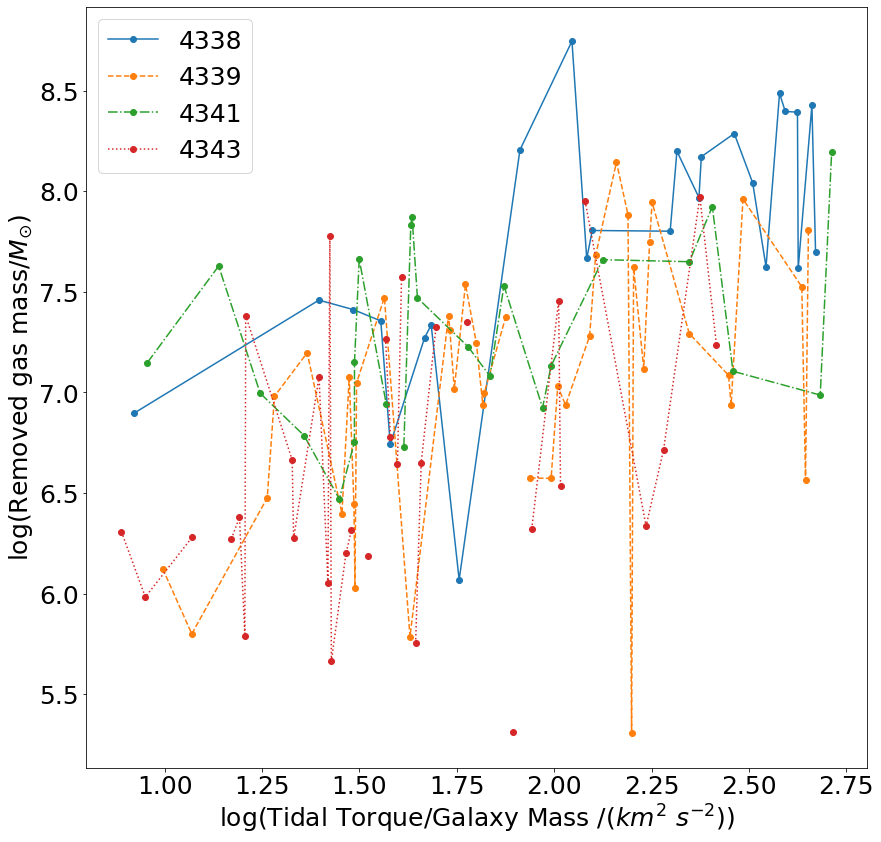

In [18]:
pl.figure(figsize=(14,14))

ii_4338 = np.argsort(TByMass_4338)
ii_4339 = np.argsort(TByMass_4339)
ii_4341 = np.argsort(TByMass_4341)
ii_4343 = np.argsort(TByMass_4343)

pl.plot(np.log10(TByMass_4338[ii_4338]), np.log10(Gas_4338[ii_4338]), label='4338', marker='o',ls='-')
pl.plot(np.log10(TByMass_4339[ii_4339]), np.log10(Gas_4339[ii_4339]), label='4339', marker='o',ls='--')
pl.plot(np.log10(TByMass_4341[ii_4341]), np.log10(Gas_4341[ii_4341]), label='4341', marker='o',ls='-.')
pl.plot(np.log10(TByMass_4343[ii_4343]), np.log10(Gas_4343[ii_4343]), label='4343', marker='o',ls=':')

pl.legend(loc='best')

pl.xlabel('log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)')
pl.ylabel('$\log($Removed gas mass$/M_{\odot})$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, '$\\log($Removed gas mass$/M_{\\odot})$')

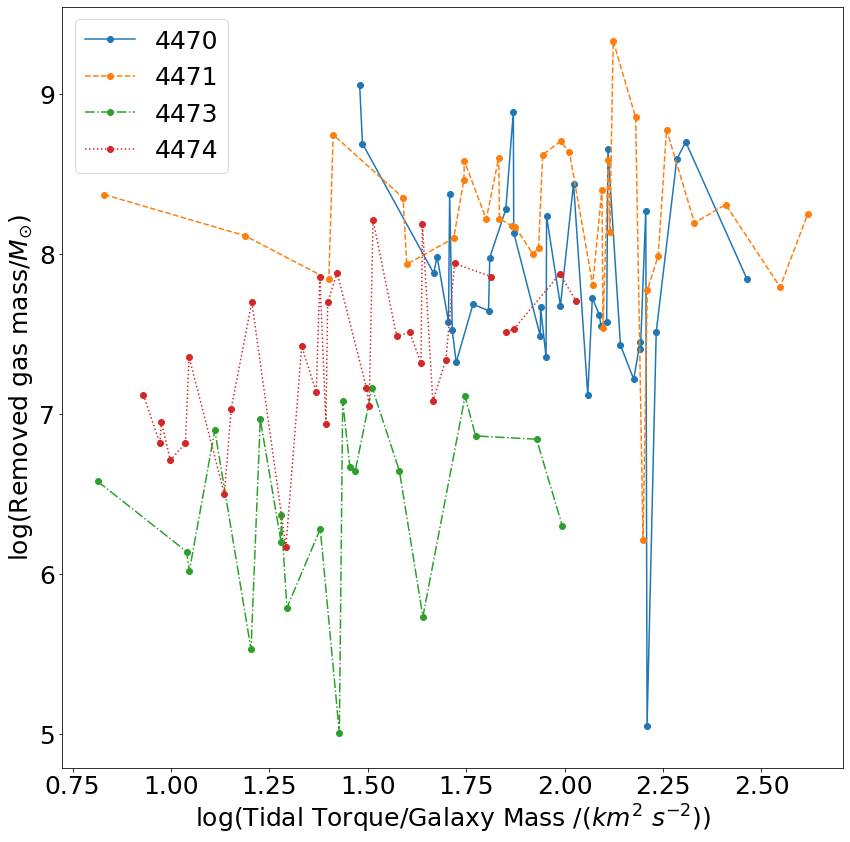

In [6]:
pl.figure(figsize=(14,14))

ii_4470 = np.argsort(TByMass_4470)
ii_4471 = np.argsort(TByMass_4471)
ii_4473 = np.argsort(TByMass_4473)
ii_4474 = np.argsort(TByMass_4474)

pl.plot(np.log10(TByMass_4470[ii_4470]), np.log10(Gas_4470[ii_4470]), label='4470', marker='o',ls='-')
pl.plot(np.log10(TByMass_4471[ii_4471]), np.log10(Gas_4471[ii_4471]), label='4471', marker='o',ls='--')
pl.plot(np.log10(TByMass_4473[ii_4473]), np.log10(Gas_4473[ii_4473]), label='4473', marker='o',ls='-.')
pl.plot(np.log10(TByMass_4474[ii_4474]), np.log10(Gas_4474[ii_4474]), label='4474', marker='o',ls=':')

pl.legend(loc='best')

pl.xlabel('log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)')
pl.ylabel('$\log($Removed gas mass$/M_{\odot})$')

In [7]:
np.mean(TByMass_4338), np.mean(TByMass_4339), np.mean(TByMass_4341), np.mean(TByMass_4343)

(204.5940763219483, 124.01357287378323, 108.84791062911572, 64.78312790636781)

In [8]:
np.std(TByMass_4338)/np.sqrt(TByMass_4338.size), np.std(TByMass_4339)/np.sqrt(TByMass_4339.size), np.std(TByMass_4341)/np.sqrt(TByMass_4341.size), np.std(TByMass_4343)/np.sqrt(TByMass_4343.size)

(31.120431300539526, 18.242827952427938, 27.255769360845402, 9.67735361852147)

In [9]:
np.mean(TByMass_4470), np.mean(TByMass_4471), np.mean(TByMass_4473), np.mean(TByMass_4474)

(106.61709840423796, 115.97406048622116, 32.41437934494915, 36.23780902614169)

In [10]:
np.std(TByMass_4470)/np.sqrt(TByMass_4470.size), np.std(TByMass_4471)/np.sqrt(TByMass_4471.size), np.std(TByMass_4473)/np.sqrt(TByMass_4473.size), np.std(TByMass_4474)/np.sqrt(TByMass_4474.size)

(9.281552692200082, 15.104221328840106, 5.1552722256743255, 4.498424272774036)

In [11]:
def smoother(TByMass, Mass, n):
    I = np.arange(TByMass.size)
    
    newTByMass, newMass = np.zeros(I.size), np.zeros(I.size),
    for i in I:
        itemp = np.arange(i-n, i+n+1)
        itemp = itemp[np.where((itemp>=0) & (itemp<I[-1]))]
        tTByMass = TByMass[itemp]
        tMass = Mass[itemp]

        tTByMass = tTByMass[np.where((np.isnan(tTByMass)==False) & (np.isinf(tTByMass)==False))]
        tMass = tMass[np.where((np.isnan(tMass)==False) & (np.isinf(tMass)==False))]
        
        newTByMass[i] = np.mean(tTByMass)
        newMass[i] = np.mean(tMass)
        
    return newTByMass, newMass

In [12]:
n = 3

newTByMass_4338, newMass_4338 = smoother(TByMass_4338, Gas_4338, n)
newTByMass_4339, newMass_4339 = smoother(TByMass_4339, Gas_4339, n)
newTByMass_4341, newMass_4341 = smoother(TByMass_4341, Gas_4341, n)
newTByMass_4343, newMass_4343 = smoother(TByMass_4343, Gas_4343, n)

newTByMass_4470, newMass_4470 = smoother(TByMass_4470, Gas_4470, n)
newTByMass_4471, newMass_4471 = smoother(TByMass_4471, Gas_4471, n)
newTByMass_4473, newMass_4473 = smoother(TByMass_4473, Gas_4473, n)
newTByMass_4474, newMass_4474 = smoother(TByMass_4474, Gas_4474, n)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


Text(1.2370972323047928, 4.698253721071132, 'h4671')

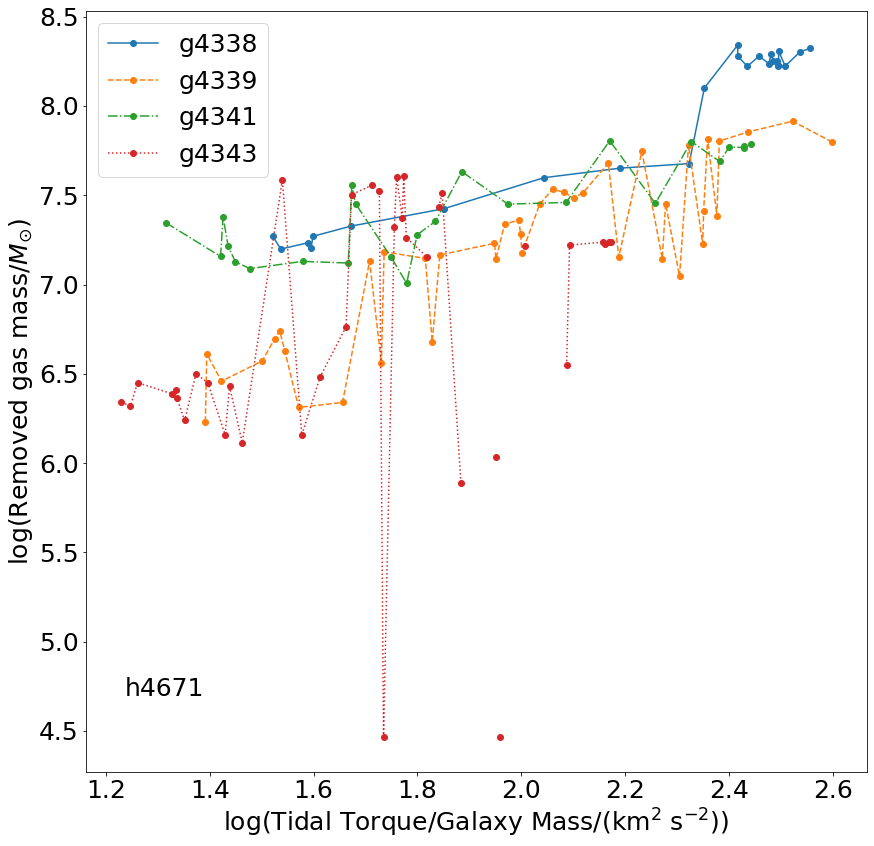

In [13]:
pl.figure(figsize=(14,14))

ii_4338 = np.argsort(newTByMass_4338)
ii_4339 = np.argsort(newTByMass_4339)
ii_4341 = np.argsort(newTByMass_4341)
ii_4343 = np.argsort(newTByMass_4343)

pl.plot(np.log10(newTByMass_4338[ii_4338]), np.log10(newMass_4338[ii_4338]), label='g4338', marker='o',ls='-')
pl.plot(np.log10(newTByMass_4339[ii_4339]), np.log10(newMass_4339[ii_4339]), label='g4339', marker='o',ls='--')
pl.plot(np.log10(newTByMass_4341[ii_4341]), np.log10(newMass_4341[ii_4341]), label='g4341', marker='o',ls='-.')
pl.plot(np.log10(newTByMass_4343[ii_4343]), np.log10(newMass_4343[ii_4343]), label='g4343', marker='o',ls=':')

pl.legend(loc='best')

pl.xlabel('log(Tidal Torque/Galaxy Mass/(km$^2$ s$^{-2})$)')
pl.ylabel('$\log($Removed gas mass$/M_{\odot})$')

xlim = pl.xlim()
ylim = pl.ylim()

xdelta = xlim[1]-xlim[0]
ydelta = ylim[1]-ylim[0]

pl.text(xlim[0]+xdelta/20, ylim[0]+ydelta/10, 'h4671')

Text(2.127550635496368, 6.036181045031558, 'h4672')

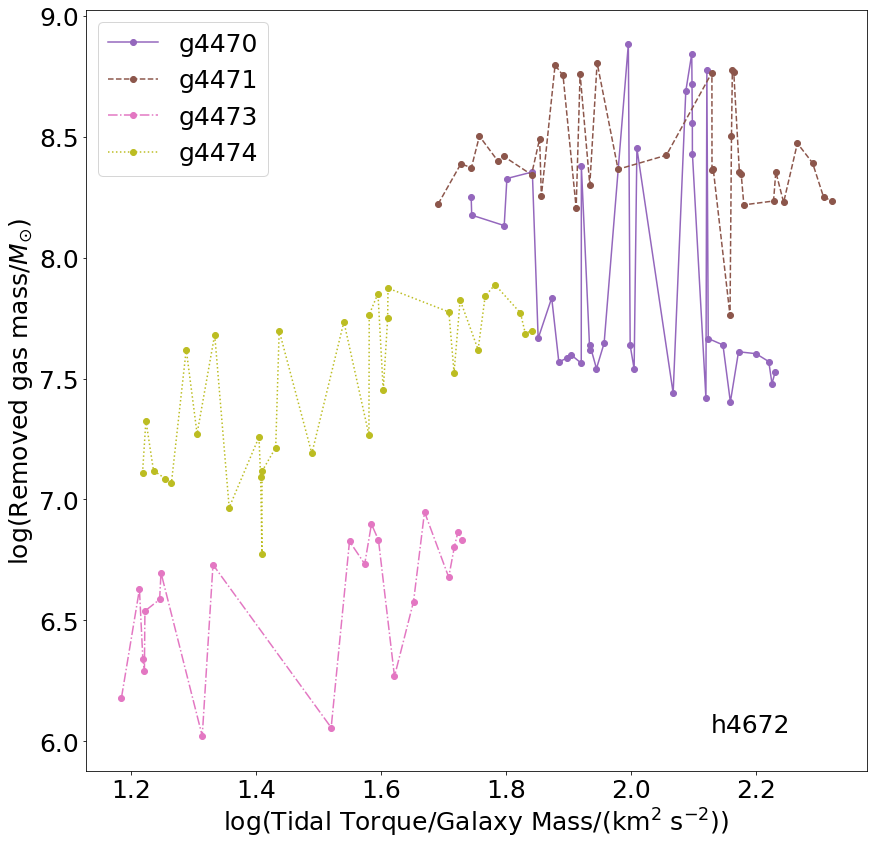

In [14]:
pl.figure(figsize=(14,14))

ii_4470 = np.argsort(newTByMass_4470)
ii_4471 = np.argsort(newTByMass_4471)
ii_4473 = np.argsort(newTByMass_4473)
ii_4474 = np.argsort(newTByMass_4474)

pl.plot(np.log10(newTByMass_4470[ii_4470]), np.log10(newMass_4470[ii_4470]), label='g4470', marker='o',ls='-', color='tab:purple')
pl.plot(np.log10(newTByMass_4471[ii_4471]), np.log10(newMass_4471[ii_4471]), label='g4471', marker='o',ls='--', color='tab:brown')
pl.plot(np.log10(newTByMass_4473[ii_4473]), np.log10(newMass_4473[ii_4473]), label='g4473', marker='o',ls='-.', color='tab:pink')
pl.plot(np.log10(newTByMass_4474[ii_4474]), np.log10(newMass_4474[ii_4474]), label='g4474', marker='o',ls=':', color='tab:olive')

pl.legend(loc='best')

pl.xlabel('log(Tidal Torque/Galaxy Mass/(km$^2$ s$^{-2})$)')
pl.ylabel('$\log($Removed gas mass$/M_{\odot})$')

xlim = pl.xlim()
ylim = pl.ylim()

xdelta = xlim[1]-xlim[0]
ydelta = ylim[1]-ylim[0]

pl.text(xlim[1]-xdelta/5, ylim[0]+ydelta/20, 'h4672')

In [24]:
def smotOne(data, n):
    I = np.arange(data.size)
    
    newData = np.zeros(I.size)
    
    for i in I:
        itemp = np.arange(i-n, i+n+1)
        itemp = itemp[np.where((itemp>=0) & (itemp<I[-1]))]
        tData = data[itemp]
        
        tData = tData[np.where((np.isnan(tData)==False) & (np.isinf(tData)==False))]
        newData[i] = np.mean(tData)
        
    return newData

Text(0, 0.5, '$\\log($Removed gas mass$/M_{\\odot})$')

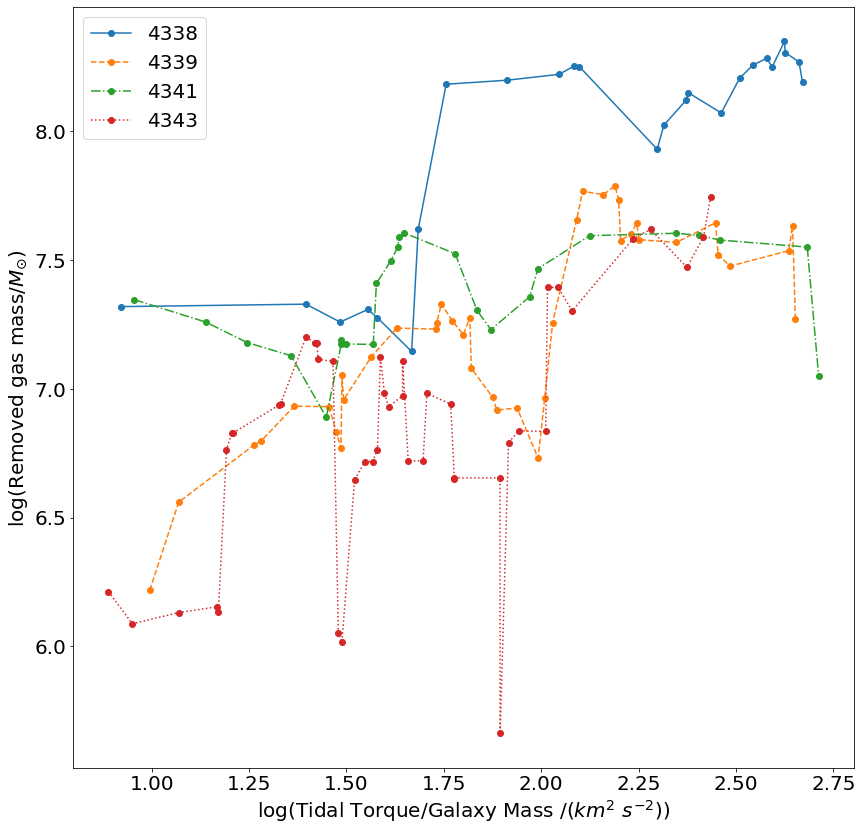

In [25]:
n = 2

pl.figure(figsize=(14,14))

ii_4338 = np.argsort(TByMass_4338)
ii_4339 = np.argsort(TByMass_4339)
ii_4341 = np.argsort(TByMass_4341)
ii_4343 = np.argsort(TByMass_4343)

newGas_S_4338 = smotOne(Gas_4338[ii_4338], n)
newGas_S_4339 = smotOne(Gas_4339[ii_4339], n)
newGas_S_4341 = smotOne(Gas_4341[ii_4341], n)
newGas_S_4343 = smotOne(Gas_4343[ii_4343], n)


pl.plot(np.log10(TByMass_4338[ii_4338]), np.log10(newGas_S_4338), label='4338', marker='o',ls='-')
pl.plot(np.log10(TByMass_4339[ii_4339]), np.log10(newGas_S_4339), label='4339', marker='o',ls='--')
pl.plot(np.log10(TByMass_4341[ii_4341]), np.log10(newGas_S_4341), label='4341', marker='o',ls='-.')
pl.plot(np.log10(TByMass_4343[ii_4343]), np.log10(newGas_S_4343), label='4343', marker='o',ls=':')

pl.legend(loc='best')

pl.xlabel('log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)')
pl.ylabel('$\log($Removed gas mass$/M_{\odot})$')

Text(0, 0.5, '$\\log($Removed gas mass$/M_{\\odot})$')

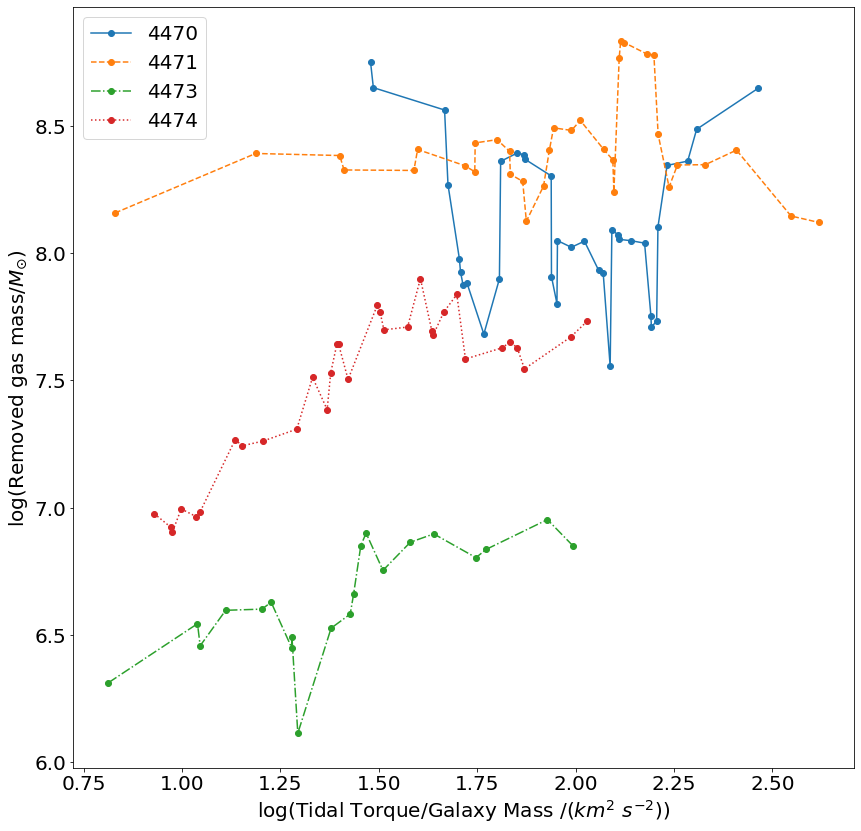

In [26]:
pl.figure(figsize=(14,14))

ii_4470 = np.argsort(TByMass_4470)
ii_4471 = np.argsort(TByMass_4471)
ii_4473 = np.argsort(TByMass_4473)
ii_4474 = np.argsort(TByMass_4474)

newGas_S_4470 = smotOne(Gas_4470[ii_4470], n)
newGas_S_4471 = smotOne(Gas_4471[ii_4471], n)
newGas_S_4473 = smotOne(Gas_4473[ii_4473], n)
newGas_S_4474 = smotOne(Gas_4474[ii_4474], n)


pl.plot(np.log10(TByMass_4470[ii_4470]), np.log10(newGas_S_4470), label='4470', marker='o',ls='-')
pl.plot(np.log10(TByMass_4471[ii_4471]), np.log10(newGas_S_4471), label='4471', marker='o',ls='--')
pl.plot(np.log10(TByMass_4473[ii_4473]), np.log10(newGas_S_4473), label='4473', marker='o',ls='-.')
pl.plot(np.log10(TByMass_4474[ii_4474]), np.log10(newGas_S_4474), label='4474', marker='o',ls=':')

pl.legend(loc='best')

pl.xlabel('log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)')
pl.ylabel('$\log($Removed gas mass$/M_{\odot})$')

# 